# Preliminaries

## Init notebook

This is run once.

In [1]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#%%capture

# Install a local package.
!pip install captum
!pip install quantus # -e drive/MyDrive/Projects/quantus/. --user  #
#!pip install git+https://github.com/understandable-machine-intelligence-lab/Quantus.git@xai-skill-score
!pip install -e drive/MyDrive/Projects/MetaQuantus/. --user #!pip install git+https://github.com/annahedstroem/MetaQuantus.git

# Reload changes.
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.9/248.9 kB 5.6 MB/s eta 0:00:00
Obtaining file:///content/drive/MyDrive/Projects/MetaQuantus
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Running setup.py develop for metaquantus


## Imports

In [1]:
import quantus
import metaquantus

In [2]:
# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"

# Import local packages.
#import sys
#path = "/content/drive/MyDrive/Projects"
#sys.path.append(f'{path}/quantus')
#sys.path.append(f'{path}/MetaQuantus')
#import quantus
#import metaquantus

# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
    !nvidia-smi
except:
    pass

Using device: NVIDIA A100-SXM4-40GB
Mon Sep 11 08:50:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    50W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                    

In [3]:
colab = True

if colab:

    # To access local files, we need to mount Google Drive.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Set paths.
    PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
    PATH_DATA = PATH_ASSETS + "data/"

    # Import local packages.
    import sys
    path = "/content/drive/MyDrive/Projects"
    sys.path.append(f'{path}/MetaQuantus')
    import metaquantus

Mounted at /content/drive


## Code

In [92]:
"""This module holds a collection of loss functions i.e., ways to measure the loss between two inputs."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

import scipy
import numpy as np


def entropy(a: np.array, x: np.array, **kwargs) -> float:
    """
    Calculate entropy.

    Parameters
    ----------
    a: np.ndarray
        Array to calculate entropy on.
    x: np.ndarray
        Array to compute shape.
    kwargs: optional
            Keyword arguments.

    Returns
    -------
    float:
        A floating point, raning [0, inf].
    """
    assert (a >= 0).all(), "Entropy computation requires non-negative attributions"

    if len(x.shape) == 1:
        newshape = np.prod(x.shape)
    else:
        newshape = np.prod(x.shape[1:])

    a_reshaped = np.reshape(a, int(newshape))
    a_normalised = a_reshaped.astype(np.float64) / np.sum(np.abs(a_reshaped))
    return scipy.stats.entropy(pk=a_normalised)

def gini_coeffiient(a: np.array, x: np.array, **kwargs) -> float:
    """
    Calculate Gini coefficient.

    Parameters
    ----------
    a: np.ndarray
        Array to calculate gini_coeffiient on.
    x: np.ndarray
        Array to compute shape.
    kwargs: optional
        Keyword arguments.

    Returns
    -------
    float:
        A floating point, ranging [0, 1].

    """

    if len(x.shape) == 1:
        newshape = np.prod(x.shape)
    else:
        newshape = np.prod(x.shape[1:])

    a = np.array(np.reshape(a, newshape), dtype=np.float64)
    a += 0.0000001
    a = np.sort(a)
    score = (np.sum((2 * np.arange(1, a.shape[0] + 1) - a.shape[0] - 1) * a)) / (
        a.shape[0] * np.sum(a)
    )
    return score

def discrete_entropy(a: np.array, x: np.array, **kwargs) -> float:
    """
    Calculate discrete entropy of explanations with n_bins equidistant spaced bins
    Parameters
    ----------
    a: np.ndarray
        Array to calculate entropy on.
    x: np.ndarray
        Array to compute shape.
    kwargs: optional
        Keyword arguments.

        n_bins: int
            Number of bins. default is 100.

    Returns
    -------
    float:
        Discrete Entropy.
    """

    n_bins = kwargs.get("n_bins", 100)

    histogram, bins = np.histogram(a, bins=n_bins)

    return scipy.stats.entropy(pk=histogram)

def freedman_diaconis_rule(a_batch: np.array) -> int:
    """Freedman–Diaconis' rule."""

    iqr = np.percentile(a_batch, 75) - np.percentile(a_batch, 25)
    n = a_batch[0].ndim # Adapted this (fr. len(a_batch))
    bin_width = 2 * iqr / np.power(n, 1/3)

    # Set a minimum value for bin_width to avoid division by very small numbers.
    min_bin_width = 1e-6
    bin_width = max(bin_width, min_bin_width)

    # Calculate number of bins based on bin width.
    n_bins = int((np.max(a_batch) - np.min(a_batch)) / bin_width)

    return n_bins

def scotts_rule(a_batch: np.array) -> int:
    """Scott's rule."""

    std = np.std(a_batch)
    n = a_batch[0].ndim # Adapted this (fr. len(a_batch))

    # Calculate bin width using Scott's rule.
    bin_width = 3.5 * std / np.power(n, 1/3)

    # Calculate number of bins based on bin width.
    n_bins = int((np.max(a) - np.min(a_batch)) / bin_width)

    return n_bins


In [93]:
"""This module contains the implementation of the enhanced Model Parameter Randomisation Test metric."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Tuple,
    Union,
    Collection,
    Iterable,
)
import os
import numpy as np
from tqdm.auto import tqdm
import torch

from quantus.helpers import asserts
from quantus.helpers import warn
from quantus.helpers import utils
from quantus.helpers.model.model_interface import ModelInterface
from quantus.functions.normalise_func import normalise_by_max
#from quantus.functions import complexity_func
from quantus.metrics.base import Metric
from quantus.helpers.enums import (
    ModelType,
    DataType,
    ScoreDirection,
    EvaluationCategory,
)


class eMPRT(Metric):
    """
    Implementation of the NAME by AUTHOR et. al., 2023.

    INSERT DESC.

    References:
        1) INSERT SOURCE

    Attributes:
        -  _name: The name of the metric.
        - _data_applicability: The data types that the metric implementation currently supports.
        - _models: The model types that this metric can work with.
        - score_direction: How to interpret the scores, whether higher/ lower values are considered better.
        - evaluation_category: What property/ explanation quality that this metric measures.
    """

    name = "enhanced Model Parameter Randomisation Test"
    data_applicability = {DataType.IMAGE, DataType.TIMESERIES, DataType.TABULAR}
    model_applicability = {ModelType.TORCH, ModelType.TF}
    score_direction = ScoreDirection.HIGHER
    evaluation_category = EvaluationCategory.RANDOMISATION

    def __init__(
        self,
        complexity_func: Optional[Callable] = None,
        complexity_func_kwargs: Optional[dict] = None,
        layer_order: str = "bottom_up",
        nr_samples: Optional[int] = None,
        seed: int = 42,
        return_delta: bool = True,
        return_correlation: bool = True,
        return_average_sample_score: bool = False,
        skip_layers: bool = False,
        similarity_func: Optional[Callable] = None
        abs: bool = False,
        normalise: bool = False,
        normalise_func: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        normalise_func_kwargs: Optional[Dict[str, Any]] = None,
        return_aggregate: bool = False,
        aggregate_func: Callable = None,
        default_plot_func: Optional[Callable] = None,
        disable_warnings: bool = False,
        display_progressbar: bool = False,
        **kwargs,
    ):
        """
        Parameters
        ----------
        similarity_func: callable
            Similarity function applied to compare input and perturbed input, default=correlation_spearman.
        layer_order: string
            Indicated whether the model is randomized cascadingly or independently.
            Set order=top_down for cascading randomization, set order=independent for independent randomization,
            default="independent".
        seed: integer
            Seed used for the random generator, default=42.
        return_average_sample_score: boolean
            Indicates whether return one float per sample, representing the average
            correlation coefficient across the layers for that sample.
        abs: boolean
            Indicates whether absolute operation is applied on the attribution, default=True.
        normalise: boolean
            Indicates whether normalise operation is applied on the attribution, default=True.
        normalise_func: callable
            Attribution normalisation function applied in case normalise=True.
            If normalise_func=None, the default value is used, default=normalise_by_max.
        normalise_func_kwargs: dict
            Keyword arguments to be passed to normalise_func on call, default={}.
        return_aggregate: boolean
            Indicates if an aggregated score should be computed over all instances.
        aggregate_func: callable
            Callable that aggregates the scores given an evaluation call.
        default_plot_func: callable
            Callable that plots the metrics result.
        disable_warnings: boolean
            Indicates whether the warnings are printed, default=False.
        display_progressbar: boolean
            Indicates whether a tqdm-progress-bar is printed, default=False.
        kwargs: optional
            Keyword arguments.
        """
        if normalise_func is None:
            normalise_func = normalise_by_max

        super().__init__(
            abs=abs,
            normalise=normalise,
            normalise_func=normalise_func,
            normalise_func_kwargs=normalise_func_kwargs,
            return_aggregate=return_aggregate,
            aggregate_func=aggregate_func,
            default_plot_func=default_plot_func,
            display_progressbar=display_progressbar,
            disable_warnings=disable_warnings,
            **kwargs,
        )

        # Set seed for reproducibility.
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            os.environ['PYTHONHASHSEED'] = str(seed)

            #torch.backends.cudnn.benchmark = False
            #torch.backends.cudnn.deterministic = True
            #torch.backends.cudnn.enabled = False

        # Save metric-specific attributes.
        if complexity_func is None:
            complexity_func = entropy

        if complexity_func_kwargs is None:
            complexity_func_kwargs = {}

        if similarity_func is None:
            similarity_func = quantus.correlation_spearman

        self.complexity_func = complexity_func
        self.complexity_func_kwargs = complexity_func_kwargs
        self.similarity_func = similarity_func
        self.layer_order = layer_order
        self.nr_samples = nr_samples
        self.return_delta = return_delta
        self.return_correlation = return_correlation
        self.return_average_sample_score = return_average_sample_score
        self.skip_layers = skip_layers

        # Asserts and warnings.
        asserts.assert_layer_order(layer_order=self.layer_order)
        if not self.disable_warnings:
            warn.warn_parameterisation(
                metric_name=self.__class__.__name__,
                sensitive_params=(
                    "similarity metric 'similarity_func' and the order of "
                    "the layer randomisation 'layer_order'"
                ),
                citation=(
                    "Adebayo, J., Gilmer, J., Muelly, M., Goodfellow, I., Hardt, M., and Kim, B. "
                    "'Sanity Checks for Saliency Maps.' arXiv preprint,"
                    " arXiv:1810.073292v3 (2018)"
                ),
            )

    def __call__(
        self,
        model,
        x_batch: np.array,
        y_batch: np.array,
        a_batch: Optional[np.ndarray] = None,
        s_batch: Optional[np.ndarray] = None,
        channel_first: Optional[bool] = None,
        explain_func: Optional[Callable] = None,
        explain_func_kwargs: Optional[Dict] = None,
        model_predict_kwargs: Optional[Dict] = None,
        softmax: Optional[bool] = False,
        device: Optional[str] = None,
        batch_size: int = 64,
        custom_batch: Optional[Any] = None,
        attributions_path: str = None,
        **kwargs,
    ) -> Union[List[float], float, Dict[str, List[float]], Collection[Any]]:
        """
        This implementation represents the main logic of the metric and makes the class object callable.
        It completes instance-wise evaluation of explanations (a_batch) with respect to input data (x_batch),
        output labels (y_batch) and a torch or tensorflow model (model).

        Calls general_preprocess() with all relevant arguments, calls
        () on each instance, and saves results to evaluation_scores.
        Calls custom_postprocess() afterwards. Finally returns evaluation_scores.

        The content of evaluation_scores will be appended to all_evaluation_scores (list) at the end of
        the evaluation call.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        channel_first: boolean, optional
            Indicates of the image dimensions are channel first, or channel last.
            Inferred from the input shape if None.
        explain_func: callable
            Callable generating attributions.
        explain_func_kwargs: dict, optional
            Keyword arguments to be passed to explain_func on call.
        model_predict_kwargs: dict, optional
            Keyword arguments to be passed to the model's predict method.
        softmax: boolean
            Indicates whether to use softmax probabilities or logits in model prediction.
            This is used for this __call__ only and won't be saved as attribute. If None, self.softmax is used.
        device: string
            Indicated the device on which a torch.Tensor is or will be allocated: "cpu" or "gpu".
        kwargs: optional
            Keyword arguments.

        Returns
        -------
        evaluation_scores: list
            a list of Any with the evaluation scores of the concerned batch.

        Examples:
        --------
            # Minimal imports.
            >> import quantus
            >> from quantus import LeNet
            >> import torch

            # Enable GPU.
            >> device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Load a pre-trained LeNet classification model (architecture at quantus/helpers/models).
            >> model = LeNet()
            >> model.load_state_dict(torch.load("tutorials/assets/pytests/mnist_model"))

            # Load MNIST datasets and make loaders.
            >> test_set = torchvision.datasets.MNIST(root='./sample_data', download=True)
            >> test_loader = torch.utils.data.DataLoader(test_set, batch_size=24)

            # Load a batch of inputs and outputs to use for XAI evaluation.
            >> x_batch, y_batch = iter(test_loader).next()
            >> x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

            # Generate Saliency attributions of the test set batch of the test set.
            >> a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1)
            >> a_batch_saliency = a_batch_saliency.cpu().numpy()

            # Initialise the metric and evaluate explanations by calling the metric instance.
            >> metric = Metric(abs=True, normalise=False)
            >> scores = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch_saliency}
        """

        # Run deprecation warnings.
        warn.deprecation_warnings(kwargs)
        warn.check_kwargs(kwargs)

        data = self.general_preprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
            custom_batch=None,
            channel_first=channel_first,
            explain_func=explain_func,
            explain_func_kwargs=explain_func_kwargs,
            model_predict_kwargs=model_predict_kwargs,
            softmax=softmax,
            device=device,
        )

        # Get model and data.
        model = data["model"]
        x_batch = data["x_batch"]
        y_batch = data["y_batch"]
        a_batch = data["a_batch"]

        # Get number of iterations from number of layers.
        n_layers = len(list(model.get_random_layer_generator(order=self.layer_order)))
        model_iterator = tqdm(
            model.get_random_layer_generator(order=self.layer_order),
            total=n_layers,
            disable=not self.display_progressbar,
        )

        # Get the number of bins for discrete entropy calculation.
        if "n_bins" not in self.complexity_func_kwargs:
            self.find_n_bins(a=a_batch)


        # Compute the explanation_scores given uniformly sampled explanation.
        if self.nr_samples is None:
            self.nr_samples = len(a_batch)

        # Initialise arrays.
        self.delta_explanation_scores = np.zeros((self.nr_samples))
        self.delta_model_scores = np.zeros((self.nr_samples))
        self.explanation_random_scores = np.zeros((self.nr_samples))
        self.correlation_scores = np.zeros((self.nr_samples))
        self.explanation_scores = {}
        self.model_scores = {}

        a_batch_random = np.random.randn(*(self.nr_samples, *a_batch.shape[1:]))
        #a_batch_random = np.random.uniform(*(self.nr_samples, *a_batch.shape[1:]), low=0, high=1)
        for a_ix, a_random in enumerate(a_batch_random):
            score = self.evaluate_instance(
                        model=model,
                        x=x_batch[0],
                        y=None,
                        s=None,
                        a=a_random,
                    )
            self.explanation_random_scores[a_ix] = score

        for l_ix, (layer_name, random_layer_model) in enumerate(model_iterator):


            if l_ix == 0:

                # Generate an explanation with perturbed model.
                a_batch_original = self.explain_func(
                    model=model.get_model(),
                    inputs=x_batch,
                    targets=y_batch,
                    **self.explain_func_kwargs,
                )

                self.explanation_scores["orig"] = []
                for a_ix, a_ori in enumerate(a_batch_original):
                    score = self.evaluate_instance(
                        model=model,
                        x=x_batch[0],
                        y=None,
                        s=None,
                        a=a_ori,
                    )
                    self.explanation_scores["orig"].append(score)



                # Compute entropy of the output layer.
                self.model_scores["orig"] = []
                for y_ix, y_pred in enumerate(model.predict(x_batch)):
                    score = entropy(a=y_pred, x=y_pred)
                    self.model_scores["orig"].append(score)

            # Skip layers if computing delta.
            if self.skip_layers and self.return_delta and (l_ix+1) < len(model_iterator):
                continue

            # Score explanation complexity.
            explanation_scores_scores = []

            # Generate an explanation with perturbed model.
            a_batch_perturbed = self.explain_func(
                model=random_layer_model,
                inputs=x_batch,
                targets=y_batch,
                **self.explain_func_kwargs,
            )

            # Get id for storing data.
            if attributions_path is not None:
                savepath = os.path.join(attributions_path, f"{l_ix}-{layer_name}")
                os.makedirs(savepath, exist_ok=True)
                last_id = 0
                for fname in os.listdir(savepath):
                    if "original_attribution_" in fname:
                        id = int(fname.split("original_attribution_")[1].split(".")[0]) > last_id
                        if id > last_id:
                            last_id = id

            batch_iterator = enumerate(zip(a_batch, a_batch_perturbed))
            for instance_id, (a_ix, a_perturbed) in batch_iterator:
                score = self.evaluate_instance(
                    model=random_layer_model,
                    x=x_batch[0],
                    y=None,
                    s=None,
                    a=a_perturbed,
                )
                explanation_scores_scores.append(score)

                # Save data.
                if attributions_path is not None:
                    np.save(os.path.join(savepath, f"input_{last_id+instance_id}.npy"), x_batch[instance_id])
                    np.save(os.path.join(savepath, f"original_attribution_{last_id+instance_id}.npy"), a_ix)
                    np.save(os.path.join(savepath, f"perturbed_attribution_{last_id+instance_id}.npy"), a_perturbed)

            # Score the model complexity.
            model_scores = []

            # Wrap the model.
            random_layer_model = utils.get_wrapped_model(
                model=random_layer_model,
                channel_first=channel_first,
                softmax=softmax,
                device=device,
                model_predict_kwargs=model_predict_kwargs,
            )

            # Predict and save scores.
            y_preds = random_layer_model.predict(x_batch)
            for y_ix, y_pred in enumerate(y_preds):
                score = entropy(a=y_pred, x=y_pred)
                model_scores.append(score)

            # Save explanation_scores scores in a result dictionary.
            self.explanation_scores[layer_name] = explanation_scores_scores
            self.model_scores[layer_name] = model_scores

        # Call post-processing.
        self.custom_postprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
        )

        # If return one score per sample.
        if self.return_average_sample_score:
            self.evaluation_scores = self.recompute_average_correlation_per_sample()

        # If return correlation score (model and explanations)
        if self.return_correlation:
            self.correlation_scores = self.recompute_model_explanation_correlation_per_sample()

        # If return delta score per sample (model and explanations).
        if self.return_delta:

            # Compute deltas for explanation scores.
            scores = list(self.explanation_scores.values())
            self.delta_explanation_scores = [b / a for a, b in zip(scores[0], scores[-1])]

            # Compute deltas for model scores.
            scores = list(self.model_scores.values())
            self.delta_model_scores = [b / a for a, b in zip(scores[0], scores[-1])]

            # Set delta scores as the final output.
            self.explanation_scores = self.delta_explanation_scores

        # If return one aggregate score for all samples.
        if self.return_aggregate:
            assert self.return_average_sample_score or self.return_delta, (
                "You must set 'return_average_sample_score' or 'return_delta to True in order to compute the aggregate score."
            )
            self.explanation_scores = [self.aggregate_func(self.explanation_scores)]

        # Return all_evaluation_scores according to Quantus.
        self.all_evaluation_scores.append(self.explanation_scores)

        return self.all_evaluation_scores

    def evaluate_instance(
        self,
        model: ModelInterface,
        x: Optional[np.ndarray],
        y: Optional[np.ndarray],
        a: Optional[np.ndarray],
        s: Optional[np.ndarray],
    ) -> float:
        """
        Evaluate instance gets model and data for a single instance as input and returns the evaluation result.

        Parameters
        ----------
        i: integer
            The evaluation instance.
        model: ModelInterface
            A ModelInteface that is subject to explanation.
        x: np.ndarray
            The input to be evaluated on an instance-basis.
        y: np.ndarray
            The output to be evaluated on an instance-basis.
        a: np.ndarray
            The explanation to be evaluated on an instance-basis.
        s: np.ndarray
            The segmentation to be evaluated on an instance-basis.

        Returns
        -------
        float
            The evaluation results.
        """
        if self.normalise:
            a = self.normalise_func(a, **self.normalise_func_kwargs)

        if self.abs:
            a = np.abs(a)

        # Compute distance measure.
        return self.complexity_func(a=a, x=x, **self.complexity_func_kwargs)

    def custom_preprocess(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: Optional[np.ndarray],
        a_batch: Optional[np.ndarray],
        s_batch: np.ndarray,
        custom_batch: Optional[np.ndarray],
    ) -> None:
        """
        Implementation of custom_preprocess_batch.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model e.g., torchvision.models that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        custom_batch: any
            Gives flexibility ot the user to use for evaluation, can hold any variable.

        Returns
        -------
        None
        """
        # Additional explain_func assert, as the one in general_preprocess()
        # won't be executed when a_batch != None.

        asserts.assert_explain_func(explain_func=self.explain_func)

    def recompute_model_explanation_correlation_per_sample(
        self,
    ) -> Union[List[List[Any]], Dict[int, List[Any]]]:

        assert isinstance(self.evaluation_scores, dict), (
            "To compute the correlation between model and explanation per sample for "
            "enhanced Model Parameter Randomisation Test, 'last_result' "
            "must be of type dict."
        )
        layer_length = len(
            self.evaluation_scores[list(self.evaluation_scores.keys())[0]]
        )
        explanation_scores: Dict[int, list] = {sample: [] for sample in range(layer_length)}
        model_scores: Dict[int, list] = {sample: [] for sample in range(layer_length)}

        for sample in results:
            for layer in self.explanation_scores:
                explanation_scores[sample].append(float(self.explanation_scores[layer][sample]))
                model_scores[sample].append(float(self.model_scores[layer][sample]))

        corr_coeffs = []
        for sample in results:
            corr_coeffs.append(self.similarity_func(model_scores[sample], explanation_scores[sample]))

        return corr_coeffs

    def recompute_average_correlation_per_sample(
        self,
    ) -> Union[List[List[Any]], Dict[int, List[Any]]]:

        assert isinstance(self.evaluation_scores, dict), (
            "To compute the average correlation coefficient per sample for "
            "enhanced Model Parameter Randomisation Test, 'last_result' "
            "must be of type dict."
        )
        layer_length = len(
            self.evaluation_scores[list(self.evaluation_scores.keys())[0]]
        )
        results: Dict[int, list] = {sample: [] for sample in range(layer_length)}

        for sample in results:
            for layer in self.evaluation_scores:
                if layer == "orig":
                    continue
                results[sample].append(float(self.evaluation_scores[layer][sample]))
            results[sample] = np.mean(results[sample])

        corr_coeffs = list(results.values())

        return corr_coeffs

    def find_n_bins(self,
                   a: np.array,
                   max_n_bins: int = 200,
                   min_n_bins: int = 10,
                   debug: bool = True) -> None:

        # Compute the number of bins.
        if self.normalise:
            a_batch = self.normalise_func(a, **self.normalise_func_kwargs)

        if self.abs:
            a_batch = np.abs(a_batch)

        if debug:
            print(f"Max and min value of a_batch=({a_batch.min()}, {a_batch.max()})")
        rule: Optional[Callable] = None
        if self.complexity_func_kwargs["rule"] == "freedman_diaconis":
            rule = freedman_diaconis_rule
        elif self.complexity_func_kwargs["rule"] == "scotts":
            rule = scotts_rule
        else:
            if debug:
                print(f"No rule found, 'n_bins' set to {100}.")
            self.complexity_func_kwargs["n_bins"] = 100
            return None

        # Get the number of bins for discrete entropy calculation.
        n_bins = rule(a_batch=a_batch)

        if debug:
            print(f"Rule '{self.complexity_func_kwargs['rule']}', n_bins={n_bins}.")

        n_bins = max(min(n_bins, max_n_bins), min_n_bins)
        self.complexity_func_kwargs["n_bins"] = n_bins

        if debug:
            print(f"With min={min_n_bins} and max={min_n_bins}, 'n_bins' set to {self.complexity_func_kwargs['n_bins']}.")


In [110]:
import torch
from skimage.segmentation import slic
from skimage.color import gray2rgb

def create_feature_mask(input_tensor):
    # Assume input tensor is (C, H, W).
    C, H, W = input_tensor.shape

    # Convert tensor to numpy and transpose to (H, W, C).
    img_np = input_tensor.permute(1, 2, 0).cpu().numpy()

    # If single channel, convert to RGB.
    if C == 1:
        img_np = gray2rgb(img_np)

    # Apply SLIC.
    segments = slic(img_np, n_segments=50, compactness=10)

    # Convert segments to tensor.
    segments_tensor = torch.from_numpy(segments).squeeze()

    return segments_tensor

def create_masks_for_dataset(dataset):
    n, C, H, W = dataset.shape
    masks = torch.empty((n, H, W), dtype=torch.int)

    for i in range(n):
        masks[i] = create_feature_mask(dataset[i])

    return masks


In [95]:
def replace_none(x):
    return x if x is not None else np.nan

def plot_eMPRT_curves(scores, dataset_name, model_name, figsize=(8,4)):
    plt.figure(figsize=figsize)

    for ix, (method, data) in enumerate(scores.items()):
        if "explanation_scores" in data:
            means = []
            stds = []
            model_means = []
            model_stds = []
            layer_names = []
            for (layer, values), (_, model_values) in zip(data["explanation_scores"].items(), data["model_scores"].items()):
                layer_names.append(layer)
                values = np.vectorize(replace_none)(values)
                model_values = np.vectorize(replace_none)(model_values)
                means.append(np.nanmean(values))
                stds.append(np.nanstd(values))
                model_means.append(np.nanmean(model_values))
                model_stds.append(np.nanstd(model_values))

            # Plot!
            if ix == 0:
                plt.plot(layer_names, model_means, 'o-', label=f"Model ($\Delta$={np.mean(data['delta_model_scores']):.3f})")
                plt.fill_between(layer_names, np.array(model_means) + np.array(model_stds), np.array(model_means) - np.array(model_stds), alpha=0.2)

            # Plot!
            plt.plot(layer_names, means, 'o-', label=method + f" ($\Delta$={np.mean(data['delta_explanation_scores']):.3f}, $\rho$={np.mean(data['correlation_scores']):.3f})")
            plt.fill_between(layer_names, np.array(means) + np.array(stds), np.array(means) - np.array(stds), alpha=0.2)

    # Plot random baseline
    xai_method = list(scores.keys())[0]
    scores_random = np.vectorize(replace_none)(scores[xai_method]["explanation_random_scores"])
    scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
    scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
    plt.plot(layer_names, scores_random_means, 'o-', label="Random" + " baseline")
    plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

    plt.xticks(rotation=45)
    plt.xlabel('Layers')
    plt.ylabel('$H(\\Phi(\\cdot))$')
    plt.title(f'eMPRT curves ({dataset_name}, {model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [104]:

def setup_dataset_models_imagenet(
    dataset_name: str,
    path_assets: str,
    device: torch.device,
):

    SETTINGS = {}

    if dataset_name == "ImageNet":

        # Paths.
        # path_imagenet_model = path_assets + "models/imagenet_resnet18_model"
        path_imagenet_assets = (
            path_assets + "test_sets/imagenet_test_set_6.npy"
        )  # imagenet_test_set.npy"

        # Example for how to reload assets and models to notebook.
        model_imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
        model_imagenet_vgg16 = torchvision.models.vgg16(pretrained=True)
        model_imagenet_vit_b_16 = torchvision.models.vit_b_16(pretrained=True)
        model_imagenet_swin_t = torchvision.models.swin_t(pretrained=True)
        model_imagenet_resnet50 = torchvision.models.resnet50(pretrained=True)

        assets_imagenet = np.load(path_imagenet_assets, allow_pickle=True).item()
        x_batch_imagenet = assets_imagenet["x_batch"][:150]
        y_batch_imagenet = assets_imagenet["y_batch"][:150]
        s_batch_imagenet = assets_imagenet["s_batch"][:150]

        s_batch_imagenet = s_batch_imagenet.reshape(len(x_batch_imagenet), 1, 224, 224)

        # print(len(s_batch_imagenet))

        # Add to settings.
        SETTINGS["ImageNet"] = {
            "x_batch": x_batch_imagenet,
            "y_batch": y_batch_imagenet,
            "s_batch": s_batch_imagenet,
            "models": {
                "ResNet18": model_imagenet_resnet18,
                #"ResNet50": model_imagenet_resnet50,
                 "VGG16": model_imagenet_vgg16,
                 "ViT": model_imagenet_vit_b_16,
                 "SWIN": model_imagenet_swin_t,
            },
            "gc_layers": {
                "ResNet18": "list(model.named_modules())[61][1]",
                "VGG16": "model.features[-2]",
                "ViT": "model.blocks[-1].norm1",
                "SWIN": "model.layers[-1].blocks[-1].norm1",
            },
            "estimator_kwargs": {
                "num_classes": 1000,
                "img_size": 224,
                "features": 224 * 4,
                "percentage": 0.1,
                "nr_channels": 3,
                "patch_size": 224 * 2,
                "perturb_baseline": "uniform",
                "std_adversary": 0.5,
            },
        }
        model_name = "ResNet18"

    else:
        raise ValueError(
            "Provide a supported dataset {'MNIST', 'fMNIST', 'cMNIST' and 'ImageNet'}."
        )

    return SETTINGS, model_name



def setup_xai_settings_emprt(
    xai_settings: List[str],
    x_batch: np.array,
    gc_layer: Optional[str] = None,
    img_size: int = 28,
    nr_channels: int = 1,
) -> Dict:
    kwargs_methods = {
        "LayerGradCam": {
            "gc_layer": gc_layer,
            "interpolate": (img_size, img_size),
            "interpolate_mode": "bilinear",
        },
        "Occlusion": {"window": (nr_channels, int(img_size / 4), int(img_size / 4))},
    }

    kwargs_methods["KernelShap"] = {"n_samples": 10,
                             "return_input_shape": True,
                             "perturbations_per_eval": len(x_batch)//10,
                             "feature_mask": create_masks_for_dataset(torch.randn((len(x_batch), nr_channels, img_size, img_size)))}

    return {xai_method: kwargs_methods.get(xai_method, {}) for xai_method in xai_settings}


## Load data, models and explainers

In [ ]:
import torchvision
from metaquantus import setup_dataset_models, setup_xai_settings

In [98]:
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


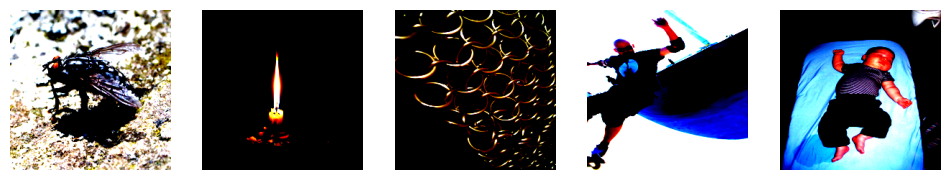

In [99]:
# Load data.
dataset_name = "ImageNet"
nr_test_samples = 200

# Get input, outputs settings.
#if dataset_name == "ImageNet":
#    dataset_settings, model_name = setup_dataset_models_imagenet(
#    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
#)
#else:
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
estimator_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"][model_name].eval()
dataset_settings[dataset_name]["models"]["Vgg16"] = torchvision.models.vgg16().eval()
#dataset_settings[dataset_name]["models"]["Vit"] = torchvision.models.vit_b_16().eval()
#dataset_settings[dataset_name]["models"]["SWIN"] = torchvision.models.swin_v2_b().eval()

dataset_settings[dataset_name]["gc_layers"]["Vgg16"] = "model.features[-2]"
#dataset_settings[dataset_name]["gc_layers"]["Vit"] = "model.blocks[-1].norm1"
#dataset_settings[dataset_name]["gc_layers"]["SWIN"] = "model.layers[-1].blocks[-1].norm1"

x_batch = dataset_settings[dataset_name]["x_batch"][:nr_test_samples]
y_batch = dataset_settings[dataset_name]["y_batch"][:nr_test_samples]
s_batch = dataset_settings[dataset_name]["s_batch"][:nr_test_samples]

dataset_kwargs = dataset_settings[dataset_name]
img_size = x_batch.shape[2]
nr_channels = x_batch.shape[1]
nr_classes = estimator_kwargs["num_classes"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(img_size, img_size, nr_channels))
    ax[i].axis("off")
plt.show()

In [ ]:
print(f"Available methods:")
for i in quantus.AVAILABLE_XAI_METHODS_CAPTUM:
    print(f"\t - {i}")

In [100]:
print(f"Available methods:")
for i in quantus.AVAILABLE_XAI_METHODS_CAPTUM:
    print(f"\t - {i}")

Available methods:
	 - GradientShap
	 - IntegratedGradients
	 - DeepLift
	 - DeepLiftShap
	 - InputXGradient
	 - Saliency
	 - FeatureAblation
	 - Deconvolution
	 - FeaturePermutation
	 - Lime
	 - KernelShap
	 - LRP
	 - Gradient
	 - Occlusion
	 - LayerGradCam
	 - GuidedGradCam
	 - LayerConductance
	 - LayerActivation
	 - InternalInfluence
	 - LayerGradientXActivation
	 - Control Var. Sobel Filter
	 - Control Var. Constant
	 - Control Var. Random Uniform


In [106]:
# Load explanations.
xai_setting = ["Saliency", "Gradient", "LayerGradCam", "LRP", "KernelShap"]

"""
# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    model = dataset_settings[dataset_name]["models"][model_name].eval().cpu()
    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

print(f"Chosen methods: {xai_methods}")
"""

'\n# Generate explanations.\nexplanations = {}\nfor method, kwargs in xai_methods.items():\n    model = dataset_settings[dataset_name]["models"][model_name].eval().cpu()\n    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})\n\nprint(f"Chosen methods: {xai_methods}")\n'

# Experimental setup

In [102]:
# Experimental setup.

# Main manuscript:

# (1)
# Plot sMPRT - showcases how noise hels reduce the inherent bias of SSIM towards gradient-based (noisy) explanation methods. (Leander)
# Includes a commentary on how computationally expensive this is.

# (2)
# Plot eMPRT curves (bottom-up with complexity estimate) + H(f(x)) + MPRT. (Anna)
# ImageNet, fMNIST, MNIST, cMNIST
# Discuss (preliminary results shows):
# (i) variation of individual starting points, showcasing the inherent noise (which comes out as bias in MPRT)
# (ii) no explanation method ends up at 'true' explanation randomness albeit full model randomisation (what does this tell us about our explanations, reminder no gt)
# (iii) due to architectural choices such as the usage of skipconnections etc, the curves are different looking for different architectures
#    - e.g., for VGG explanation complexity typically steadily rise (monotonic increase, with slight saturation)
#    - e.g., ResNet18/50 explanation complexty highly varies
#    - i.e., deducing explanation quality is inconclusive over architectures
#    - in all, suggesting that analysing the end- vs starting point (post full-randomisation) is more meaningful
# (iv) plotting H(f(x)) allows us to anchor the expectation of explanation complexity with reality, ideally H(Φ(x)) should follow H(f(x))
# (v) no explanation method follows the function complexity, measured as (normal) entropy at softmax layer (with probablities)
# (vi) there is no explanation winner against tested models or datasets

# (/3)
# (Plot eMPRT vs MPRT delta points (bar plot over datataset and models))

# (4)
# Plot Meta-Evaluation area graphs (metric reliability analysis)

# Appendix:

# (A1) - eMPRT measure choice
# Discuss the suitability/ stability of the discrete bin measure
# Include data-agnostic algorithm for picking n_bins

# Open questions:

# (i) When we run meta-evaluation, we need to make sure the metrics produce one evaluation estimate per sample
# For this purpose, is it fair to re-define MPRT using delta SSSIM (similar to how we use delta discrete entropy) or better to use last corr or AUC?
# (ii) How to best formulate an experiment that shows that discrete_entropy is a suitable/ stable measure of complexity?
# (iii) Algorithm to best choose n_bins?

## sMPRT

## eMPRT curves

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/usr

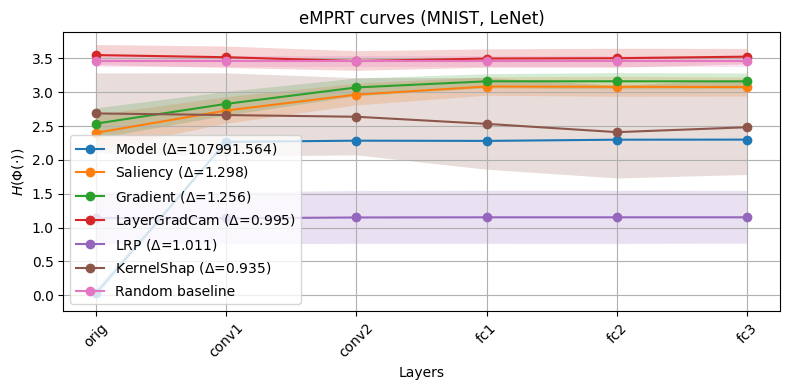

Couldn't compue the evaluation scores for Saliency method


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


AttributeError: ignored

In [112]:
nr_test_samples = 200
nr_samples = 100

# Load datasets, models and explanations.
datasets = ["MNIST", "fMNIST", "cMNIST", "ImageNet"]
xai_setting = ["Saliency", "Gradient", "LayerGradCam", "LRP", "KernelShap"]

scores = {}

for dataset_name in datasets:

    scores[dataset_name] = {}

    dataset_settings, model_name = setup_dataset_models(
        dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
    )
    estimator_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]
    dataset_kwargs = dataset_settings[dataset_name]

    if dataset_name == "ImageNet":
        dataset_kwargs["models"]["Vgg16"] = torchvision.models.vgg16().eval()
        dataset_kwargs["gc_layers"]["Vgg16"] = "model.features[-2]"
        #dataset_settings[dataset_name]["models"]["Vit"] = torchvision.models.vit_b_16().eval()
        #dataset_settings[dataset_name]["gc_layers"]["Vit"] = "model.blocks[-1].norm1"

    x_batch = dataset_kwargs["x_batch"][:nr_test_samples]
    y_batch = dataset_kwargs["y_batch"][:nr_test_samples]
    s_batch = dataset_kwargs["s_batch"][:nr_test_samples]

    for model_name in dataset_settings[dataset_name]["models"].keys():

        # Get the model.
        model = dataset_kwargs["models"][model_name]

        # Update model-specific xai parameters.
        xai_methods = setup_xai_settings_emprt(
            xai_settings=xai_setting,
            x_batch=x_batch[:nr_samples],
            gc_layer=dataset_kwargs["gc_layers"][model_name],
            img_size=estimator_kwargs["img_size"],
            nr_channels=estimator_kwargs["nr_channels"],
        )

        for xai_method, xai_method_kwargs in xai_methods.items():

            scores[dataset_name][xai_method] = {}

            # Return local MPT_Complexity estimate scores in an one-liner - by calling the metric instance.
            metric = eMPRT(
                    layer_order="bottom_up",
                    return_average_sample_score=False,
                    complexity_func=discrete_entropy,
                    complexity_func_kwargs={"rule": "freedman_diaconis"}, #scotts
                    return_delta=True,
                    return_correlation=True,
                    similarity_func=quantus.correlation_spearman,
                    skip_layers=False,
                    abs=False,
                    normalise=False,
                    #normalise_func=quantus.normalise_by_max,
                    disable_warnings=True,
                )

            try:
                # Score!
                evaluation_scores = metric(model=model,
                    x_batch=x_batch[:nr_samples],
                    y_batch=y_batch[:nr_samples],
                    softmax=True,
                    a_batch=None,
                    device=device,
                    explain_func=quantus.explain,
                    explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs},
                )

                # Results are returned/saved as a dictionary not like in the super-class as a list.
                scores[dataset_name][xai_method]["model_scores"] = metric.model_scores
                scores[dataset_name][xai_method]["explanation_scores"] = metric.explanation_scores
                scores[dataset_name][xai_method]["explanation_random_scores"] = metric.explanation_random_scores
                scores[dataset_name][xai_method]["delta_explanation_scores"] = metric.delta_explanation_scores
                scores[dataset_name][xai_method]["delta_model_scores"] = metric.delta_model_scores
                scores[dataset_name][xai_method]["delta_model_scores"] = metric.correlation_scores

            except:
                print(f"Couldn't compue the evaluation scores for {xai_method} method")

        # Plot (2), per model and dataset!
        plot_eMPRT_curves(scores[dataset_name], dataset_name, model_name, figsize=(min(len(list(model.layers)), 10), 4))

## eMPRT vs baseline (MetaQuantus)

In [ ]:
from typing import Callable

def setup_estimators(
    nr_samples: Optional[int] = None,
    layer_order: str= "bottom_up",
    complexity_func: Callable = quantus.discrete_entropy,
    similarity_func_emprt: Callable = quantus.correlation_spearman,
    similarity_func_mprt: Callable = quantus.ssim,
    abs: bool = False,
    normalise: bool = False,
    return_aggregate: bool = False
) -> Dict:
    d = {
        "Randomisation": {
            "eMPRT": {
                "init":
                eMPRT(
                    layer_order=layer_order,
                    return_delta=True,
                    return_correlation=True,
                    return_sample_quality=False,
                    complexity_func=discrete_entropy,
                    similarity_func=similarity_func_emprt,
                    complexity_func_kwargs={"n_bins": None},
                    nr_samples=nr_samples,
                    abs=abs,
                    normalise=normalise,
                    return_aggregate=return_aggregate,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                "score_direction": "higher", # eMPRT.score_direction()
            },
            "MPRT": {
                "init":
                quantus.ModelParameterRandomisation(
                    layer_order="top_down",
                    return_last_correlation=True,
                    similarity_func=similarity_func_mprt,
                    abs=abs,
                    normalise=normalise,
                    normalise_func=normalise_func.normalise_by_average_second_moment_estimate,
                    return_aggregate=return_aggregate,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                "score_direction": "lower", #  ModelParameterRandomisation.score_direction()
            },
        },
    }

In [ ]:
# Alt 1. Load initalised Quantus estimators, as provided in MetaQuantus.
estimators = setup_estimators(
    layer_order="bottom_up",
    complexity_func=quantus.discrete_entropy,
    similarity_func=quantus.ssim,
    abs=False,
    normalise=False,
    return_aggregate=False,
)
estimators

NameError: ignored